In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("RdBu_r", 7))

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.models import Sequential, save_model, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import  Activation,Dense, Input, Dropout,Flatten,SeparableConv2D, MaxPool2D \
     ,Conv2D,SeparableConv1D,BatchNormalization \
     ,GlobalMaxPooling2D, GlobalAveragePooling2D,MaxPooling2D

from keras.layers.pooling import _GlobalPooling1D
from keras.regularizers import l2

%matplotlib inline

Using TensorFlow backend.


In [2]:
IMAGEDIR=os.path.dirname('./img_align_celeba/')
DIRECTORY = './img_align_celeba'
ENTRENAR = False

### Carga de Datos

In [ ]:
#Carga los datos y solo nos quedamos con las columnas que nos interesan
df = pd.read_csv('./list_attr_celeba.csv',sep=',',dtype=str)
df= df[['Smiling','image_id']]

#Reemplaza los 1 y -1 por si y no
df['Smiling'] = df['Smiling'].replace('1','si')
df['Smiling'] = df['Smiling'].replace('-1','no')

#Realiza las particiones
div = pd.read_csv('./list_eval_partition.csv',sep=',',dtype=str)
join=df.join(div.set_index('image_id'),on='image_id')
df_train = join[join.partition == '0']
df_test = join[join.partition == '2']
df_validation = join[join.partition == '1']

#Elimina la columna de mas
df_train=df_train.drop(['partition'],axis=1)
df_test=df_test.drop(['partition'],axis=1)
df_validation=df_validation.drop(['partition'],axis=1)


### Análisis exploratorio

Podemos observar la cantidad de datos en cada conjunto

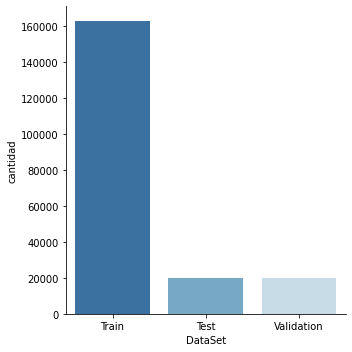

In [4]:
data = pd.DataFrame(
    {
        'DataSet':['Train','Test','Validation'],
        'cantidad':
            [
                df_train.shape[0],
                df_test.shape[0],
                df_validation.shape[0]
            ]
    })
sns.catplot(x='DataSet',y='cantidad',data= data,kind='bar')

### Descripcion de la variable de salida y balanceo

In [5]:
df.Smiling.describe()

count     202599
unique         2
top           no
freq      104930
Name: Smiling, dtype: object

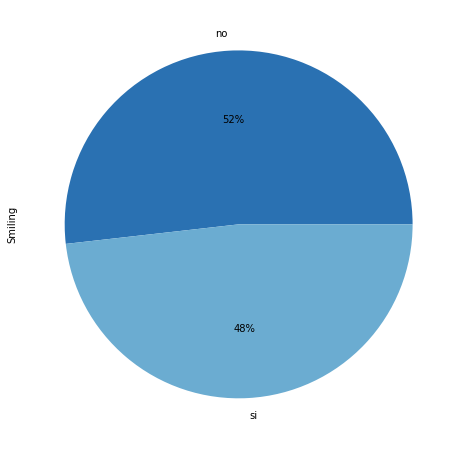

In [6]:
df.Smiling.value_counts().plot.pie(autopct='%1.0f%%', figsize=(8,8))

### Imagenes
Se trabajara con imagenes RGB con un tamaño de 70x70

### Modelos
* #### Modelo 1: MLP Simple con las siguientes capas:
    * Flatten(input_shape=(70,70,3))
    * Densa con 100 neuronas y funcion de activacion 'relu'
    * Densa con 100 neuronas y funcion de activacion 'relu'
    * Dropout con 0.2
    * Densa con 100 neuronas y funcion de activacion 'relu'
    * Densa con 1 neuronas y funcion de activacion 'sigmoid'
* #### Modelo 2: MLP Simple con las siguientes capas:
    * Flatten(input_shape=(70,70,3))
    * Densa con 250 neuronas y funcion de activacion 'relu'
    * Densa con 125 neuronas y funcion de activacion 'relu'
    * Dropout con 0.2
    * Densa con 100 neuronas y funcion de activacion 'relu'
    * Densa con 100 neuronas y funcion de activacion 'relu'
    * Dropout con 0.2
    * Densa con 30 neuronas y funcion de activacion 'relu'
    * Densa con 1 neuronas y funcion de activacion 'sigmoid' 
* #### Modelo 3: CNN1 con las siguientes capas:
    * Convolucion, 128 filtros, tamaño del filtro (3, 3), strides=(1, 1),funcion de activacion 'relu'
    * Convolucion, 256 filtros, tamaño del filtro (3, 3), strides=(1, 1),funcion de activacion 'relu'
    * MaxPolling kernel=3 strides=(2,2)
    * Convolucion, 128 filtros, tamaño del filtro (3, 3), strides=(1, 1),funcion de activacion 'relu'
    * Convolucion, 64 filtros, tamaño del filtro (3, 3), strides=(1, 1),funcion de activacion 'relu'
    * MaxPolling kernel=3 strides=(2,2)
    * Flatten
    * Densa con 64 neuronas y funcion de activacion 'relu'
    * Densa con 1 neurona y funcion de activacion 'sigmoid'
* #### Modelo 4: CNN1 con las siguientes capas:
    * Convolucion, 32 filtros, tamaño del filtro (3, 3), strides=(2, 2),padding="same"
    * BatchNormalization
    * Activation("relu")
    * Convolucion, 64 filtros, tamaño del filtro (3, 3), strides=(2, 2),padding="same"
    * BatchNormalization
    * Activation("relu")
    * for t in [128,256,512,728]:
        * Activation("relu")
        * SeparableConv2D(t, 3, padding="same")
        * BatchNormalization
        * Activation("relu")
        * SeparableConv2D(t, 3, padding="same")
        * BatchNormalization
        * MaxPolling kernel=3 strides=2, padding="same"
        * Convolucion, t neuronas, tamaño del filtro (1, 1), strides=2,padding="same"
    * SeparableConv2D(1024, 3, padding="same")
    * BatchNormalization
    * Activation("relu")
    * GlobalAveragePooling2D
    * Densa con 1 neurona y funcion de activacion 'sigmoid'




### Funciones Utiles

In [57]:
def obtener_ejemplo():
    persona=df.sample(1)[['image_id','Smiling']]
    imagen_id = persona['image_id'].values[0]
    sonrie = persona['Smiling'].values[0]
    image=load_img(os.path.join(IMAGEDIR,imagen_id))
    display('sonrie: '+sonrie)
    display(image)

def plot_history(history):
    plt.figure(0)  
    plt.plot(history.history['accuracy'],'r')  
    plt.plot(history.history['val_accuracy'],'g')  
    plt.xticks(np.arange(0, 20, 1.0))  
    plt.rcParams['figure.figsize'] = (8, 6)  
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Accuracy")  
    plt.title("Training Accuracy vs Validation Accuracy")  
    plt.legend(['train','validation'])
    
    plt.figure(1)  
    plt.plot(history.history['loss'],'r')  
    plt.plot(history.history['val_loss'],'g')  
    plt.xticks(np.arange(0, 20, 1.0))  
    plt.rcParams['figure.figsize'] = (8, 6)  
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Loss")  
    plt.title("Training Loss vs Validation Loss")  
    plt.legend(['train','validation'])

    plt.show()

def predecir(model,generator,cantidad = None):
    class_names=['no','si']
    image_batch, classes_batch = next(generator)
    predicted_batch = model.predict(image_batch)
    aciertos=[]
    errados=[]
    for k in range(0,image_batch.shape[0]):
        image = image_batch[k]
        predijo_prob = predicted_batch[k][0]
        predijo = int(round(predicted_batch[k][0]))
        nombre_clase_que_predijo = class_names[predijo]
        clase_real = int(classes_batch[k])
        nombre_clase_real = class_names[clase_real]
        predijo_bien = (predijo == clase_real)
        if cantidad == None:
            plt.figure(k)
            titulo = str(predijo_bien) + ' - class: '
            titulo += str(nombre_clase_real) + ' - ' + 'predicted: '
            titulo += str(nombre_clase_que_predijo)+' Valor arrojado en prediccion: '
            titulo += str(predijo_prob)
            plt.title(titulo) 
            plt.imshow(image)
        else:
            if predijo_bien:
                if len(aciertos)< cantidad:
                    aciertos.append(
                        (
                            nombre_clase_real,
                            nombre_clase_que_predijo,
                            predijo_prob,
                            image
                        )
                    )
            else:
                if len(errados)< cantidad:
                    errados.append(
                        (
                            nombre_clase_real,
                            nombre_clase_que_predijo,
                            predijo_prob,
                            image)
                    )
            
            if len(aciertos)==cantidad and len(errados)==cantidad:
                break

    if cantidad != None:
        display('Predicciones Acertadas')
        for valor_verdadero,calse_predijo,predijo,imag in aciertos:
            plt.title('Verdadero'+'- valor verdadero:'+ str(valor_verdadero) + ' - ' + 'predicción: ' + str(calse_predijo)+' Valor de predicción: ' +str(predijo))
            plt.imshow(imag)
            plt.show()
        display('Predicciones Erradas')
        for valor_verdadero,calse_predijo,predijo,imag in errados:
            plt.title('Valor verdadero:'+ str(valor_verdadero) + ' - ' + 'predicción: ' + str(calse_predijo)+' Valor de predicción: ' + str(predijo))
            plt.imshow(imag)
            plt.show()
        
        
def evaluar_modelo(modelo,generators):
        for data,generator in generators:
            generator.reset()
            ypred=modelo.predict_generator(generator)
            loss, accuracy=modelo.evaluate_generator(generator)
            print('Evaluar Modelo ',data,': -accuracy: ',accuracy,' -loss:',loss)
            print('accuracy_score :', accuracy_score(generator.classes, np.around(ypred)))
            cm = confusion_matrix(generator.classes,np.around(ypred))
            plt.title('Matriz de Confusión ')
            plt.xlabel("Predijo")
            plt.ylabel("Valor Real")
            plt.xticks([0,1],['no','si'],rotation=45)
            plt.yticks([0,1],['no','si'])
            plt.imshow(cm, cmap=plt.cm.Blues)
            plt.colorbar()
            plt.show()

In [8]:
df_datagen = ImageDataGenerator(
    rescale=1./255
)

df_generator_train = df_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=DIRECTORY,
    x_col='image_id',
    y_col='Smiling',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    target_size=(70,70)
)
df_generator_test = df_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=DIRECTORY,
    x_col='image_id',
    y_col='Smiling',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42,
    target_size=(70,70)
)
df_generator_val = df_datagen.flow_from_dataframe(
    dataframe=df_validation,
    directory=DIRECTORY,
    x_col='image_id',
    y_col='Smiling',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42,
    target_size=(70,70)
)

Found 162770 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.


In [9]:
if not ENTRENAR:
    model = load_model('model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [10]:
if not ENTRENAR:
    model_2 = load_model('model_2.h5')

In [11]:
if not ENTRENAR:
    model_3 = load_model('model_3.h5')

In [12]:
if not ENTRENAR:
    model_4 = load_model('model_4.h5')

In [13]:
if ENTRENAR:
    model = Sequential([
        Flatten(input_shape=(70,70,3)),

        Dense(100, activation='relu'),
        Dense(100, activation='relu'),

        Dropout(0.2),

        Dense(100, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    model.summary()

    df_generator_train.reset()
    df_generator_test.reset()
    history=model.fit(
        df_generator_train,
        epochs=4,
        workers=4,
        validation_data=df_generator_test,
    )

In [14]:
if ENTRENAR:
    plot_history(history)

In [15]:
if ENTRENAR:
    model_2 = Sequential([
        Flatten(input_shape=(70,70,3)),

        Dense(250, activation='relu'),
        Dense(125, activation='relu'),

        Dropout(0.2),

        Dense(100, activation='relu'),
        Dense(100, activation='relu'),

        Dropout(0.2),


        Dense(30, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])


    model_2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',],
    )
    model_2.summary()

    df_generator_test.reset()
    df_generator_train.reset()
    history_2=model_2.fit(
        df_generator_train,
        epochs=5,
        workers=4,
        validation_data=df_generator_test
    )

In [16]:
if ENTRENAR:
    plot_history(history_2)

In [17]:
if ENTRENAR:
    model_3 = Sequential()
    model_3.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu', input_shape=(70, 70, 3)))
    model_3.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu'))
    model_3.add(MaxPooling2D(3, strides=(2, 2)))
    model_3.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
    model_3.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
    model_3.add(MaxPooling2D(3, strides=(2, 2)))
    model_3.add(Flatten())
    model_3.add(Dense(64, activation='relu'))
    model_3.add(Dense(1, activation='sigmoid'))

    model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_3.summary()

    df_generator_test.reset()
    df_generator_train.reset()
    history_3 = model_3.fit_generator(
            df_generator_train,
            steps_per_epoch=1000,
            epochs=3,
            validation_data=df_generator_test,
            validation_steps=400)

In [18]:
if ENTRENAR:
    plot_history(history_3)

In [19]:
if ENTRENAR:
    save_model(
        model,
        'model.h5',
        overwrite=True,
        include_optimizer=True,
    )
    save_model(
        model_2,
        'model_2.h5',
        overwrite=True,
        include_optimizer=True,
    )
    save_model(
        model_3,
        'model_3.h5',
        overwrite=True,
        include_optimizer=True,
    )

In [20]:
if ENTRENAR:
    model_4 = Sequential()

    model_4.add(Conv2D(32, 3, strides=2,input_shape=(70, 70, 3), padding="same"))
    model_4.add(BatchNormalization())
    model_4.add(Activation("relu"))

    model_4.add(Conv2D(64, 3, strides=2, padding="same"))
    model_4.add(BatchNormalization())
    model_4.add(Activation("relu"))

    for t in [128,256,512,728]:
        model_4.add(Activation("relu"))
        model_4.add(SeparableConv2D(t, 3, padding="same"))
        model_4.add(BatchNormalization())

        model_4.add(Activation("relu"))
        model_4.add(SeparableConv2D(t, 3, padding="same"))
        model_4.add(BatchNormalization())

        model_4.add(MaxPooling2D(3, strides=2, padding="same"))
        model_4.add(Conv2D(t, 1, strides=2, padding="same"))

    model_4.add(SeparableConv2D(1024, 3, padding="same"))
    model_4.add(BatchNormalization())
    model_4.add(Activation("relu"))

    model_4.add(GlobalAveragePooling2D())

    model_4.add(Dense(1, activation='sigmoid'))

    model_4.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [21]:
if ENTRENAR:
    df_generator_test.reset()
    df_generator_train.reset()
    history_4=model_4.fit(
            df_generator_train,
            epochs=10,
            workers=4,
            validation_data=df_generator_test
    )

In [22]:
if ENTRENAR:
    plot_history(history_4)

In [23]:
if ENTRENAR:
    save_model(
        model_4,
        'model_4.h5',
        overwrite=True,
        include_optimizer=True,
    )

MLP Simple 1
Evaluar Modelo  train : -accuracy:  0.8961663842201233  -loss: 0.21743179857730865
accuracy_score : 0.5031946918965411


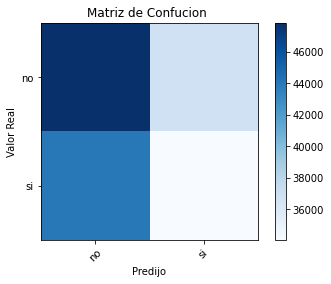

Evaluar Modelo  test : -accuracy:  0.8926961421966553  -loss: 0.20667213201522827
accuracy_score : 0.8926961226330027


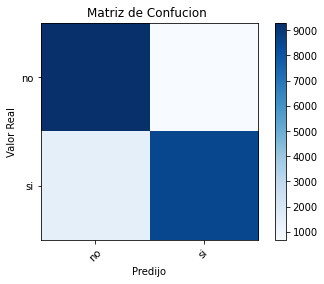

Evaluar Modelo  val : -accuracy:  0.8956561088562012  -loss: 0.2523365616798401
accuracy_score : 0.8956561131524639


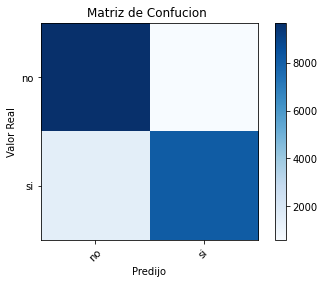

MLP Simple 2
Evaluar Modelo  train : -accuracy:  0.9000614285469055  -loss: 0.21386604011058807
accuracy_score : 0.5014253240769183


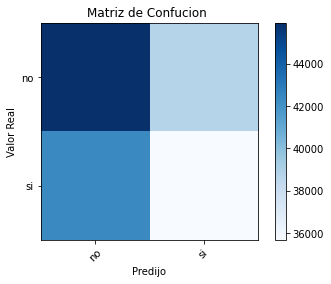

Evaluar Modelo  test : -accuracy:  0.8970543742179871  -loss: 0.22940737009048462
accuracy_score : 0.8970544033663962


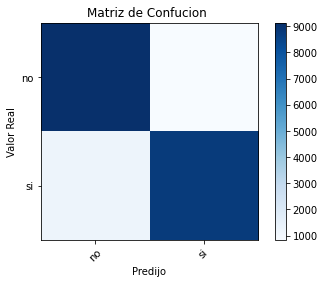

Evaluar Modelo  val : -accuracy:  0.8987768888473511  -loss: 0.26048263907432556
accuracy_score : 0.8987768661599638


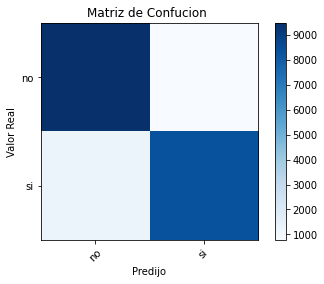

CNN 1
Evaluar Modelo  train : -accuracy:  0.9028998017311096  -loss: 0.19024744629859924
accuracy_score : 0.49886957055968545


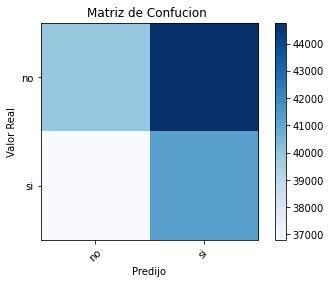

Evaluar Modelo  test : -accuracy:  0.8990582227706909  -loss: 0.19495470821857452
accuracy_score : 0.8990582106001402


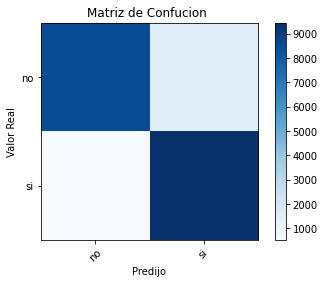

Evaluar Modelo  val : -accuracy:  0.8989278674125671  -loss: 0.5503484606742859
accuracy_score : 0.898927870337746


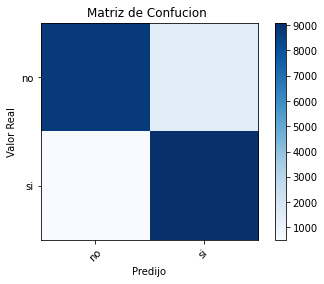

CNN 2
Evaluar Modelo  train : -accuracy:  0.9654358625411987  -loss: 0.07425044476985931
accuracy_score : 0.5001413036800393


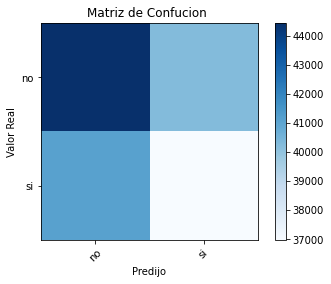

Evaluar Modelo  test : -accuracy:  0.9063220024108887  -loss: 0.342464417219162
accuracy_score : 0.9063220118224626


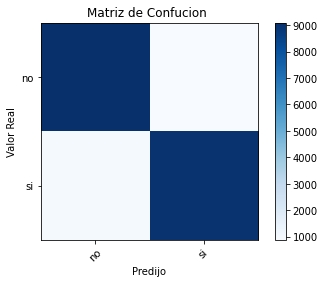

Evaluar Modelo  val : -accuracy:  0.914179265499115  -loss: 0.3346218764781952
accuracy_score : 0.9141792922937535


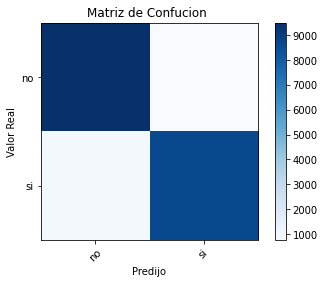

In [52]:
tipos_gen=('train','test','val')
generadores =(df_generator_train,df_generator_test,df_generator_val)
modelos = ((model,'MLP Simple 1'),(model_2,'MLP Simple 2'),(model_3,'CNN 1'),(model_4,'CNN 2'))
for modelo,nombre in modelos:
    print(nombre)
    evaluar_modelo(modelo,zip(tipos_gen,generadores))

MLP Simple 1


'Predicciones Acertadas'

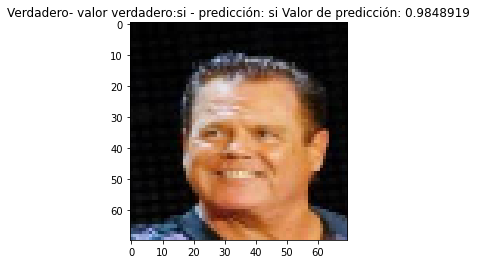

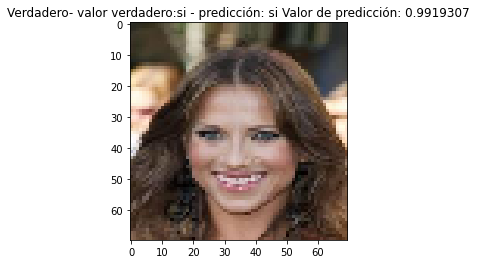

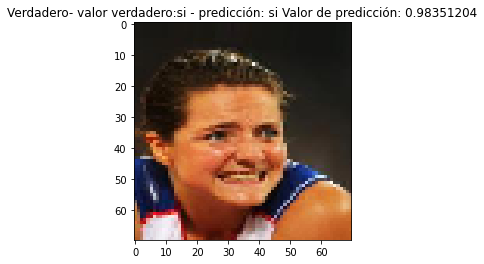

'Predicciones Erradas'

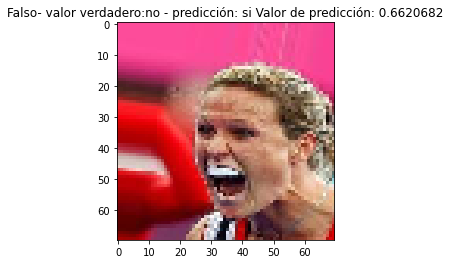

MLP Simple 2


'Predicciones Acertadas'

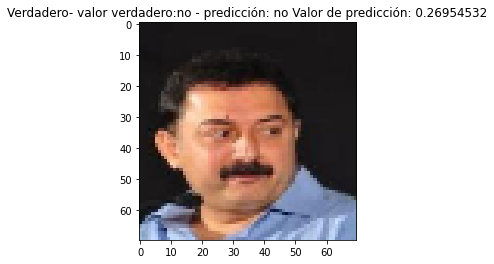

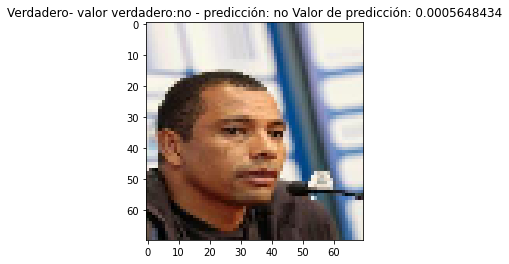

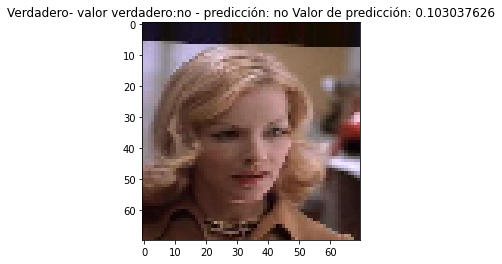

'Predicciones Erradas'

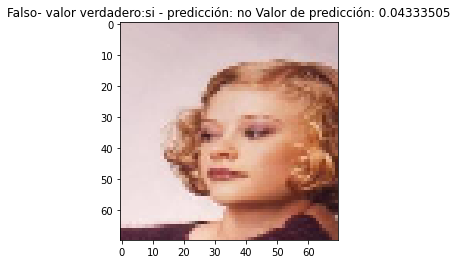

CNN 1


'Predicciones Acertadas'

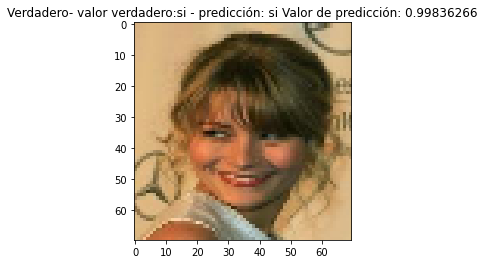

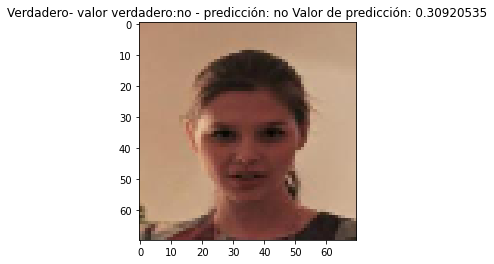

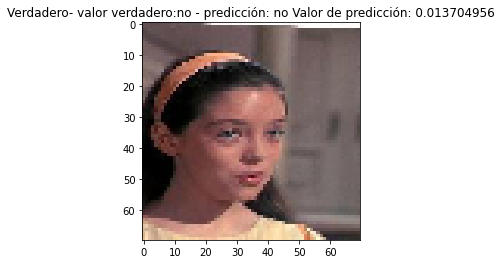

'Predicciones Erradas'

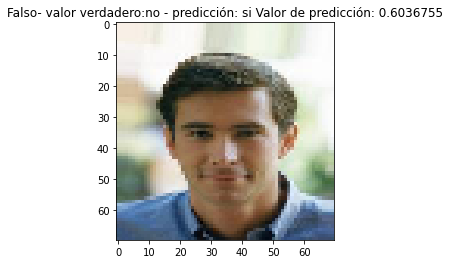

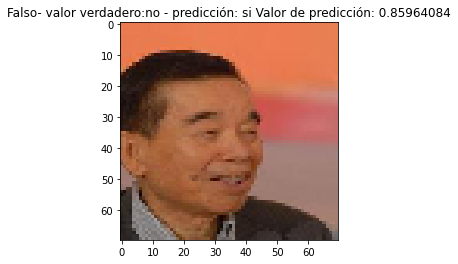

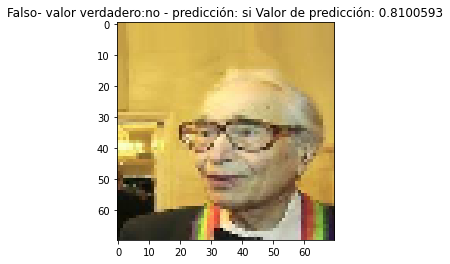

CNN 2


'Predicciones Acertadas'

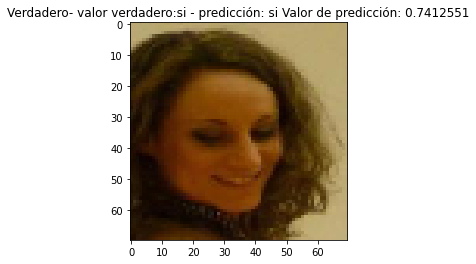

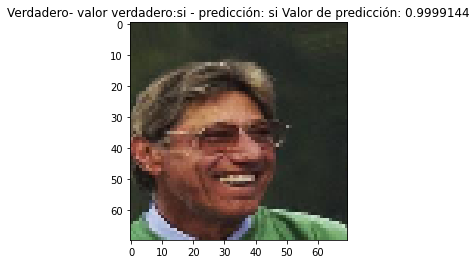

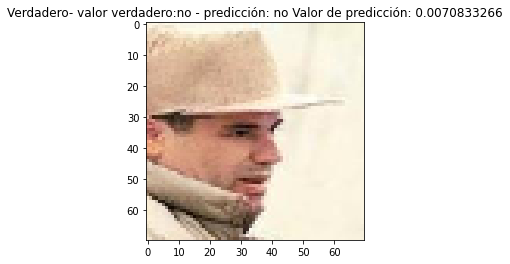

'Predicciones Erradas'

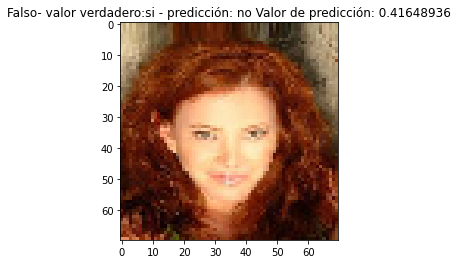

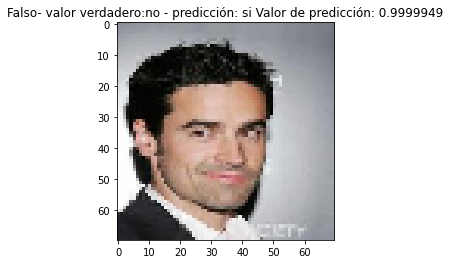

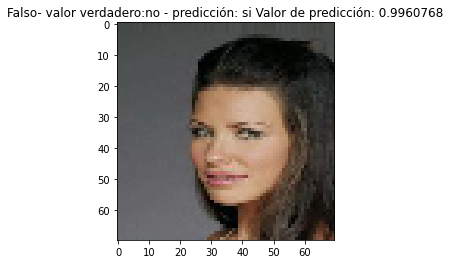

In [60]:
modelos = ((model,'MLP Simple 1'),(model_2,'MLP Simple 2'),(model_3,'CNN 1'),(model_4,'CNN 2'))
for modelo,nombre in modelos:
    print(nombre)
    predecir(modelo,df_generator_val,3)

## Conclusiones

#### Decisión Final
Nos quedamos con el modelo 4 ya que es con el cual logramos mejores resultados 0.91 con el dataset de Validation.
Si bien con los demas modelos tambien obtenemos resultados positivos (0.89,0.91].  
Una posible mejora seria entrenar por mas tiempo los modelos o agregarle mas capas y observar su evolucion.